# 📊 Analysis: Column Mapping Justification

This notebook explores the statistical and structural relationships between the columns to justify the inferred mapping.

# Finding volume
Since volume is the number of traded stocks, it must be an integer value and greater than all other values in the row

In [2]:
import pandas as pd

mapping = pd.read_json("mapping.json")
df = pd.read_csv("02_sample_data_with_fabricated_columns.csv")

In [3]:
is_integer = (df["neutronCount"] % 1 == 0).all()
other_cols = df.drop(columns=["neutronCount"])
is_larger = (df["neutronCount"] > other_cols.max(axis=1)).all()
if (is_integer and is_larger):
    print("neutronCount is volume")

neutronCount is volume


,deltaX,gamma,omega,flux,pulse,neutronCount
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,95.209593,95.402143,95.016844,95.209804,95.209737,50541.730472
std,103.796442,103.796594,103.797184,103.797320,103.796308,28578.459770
min,-211.728008,-211.323966,-211.882648,-211.767355,-211.500164,1000.000000
25%,39.445254,39.632531,39.242162,39.438783,39.449301,25810.000000
50%,114.096853,114.286186,113.906685,114.114242,114.092463,50604.000000
75%,175.434137,175.621276,175.241753,175.425143,175.434474,75257.000000
max,286.705521,286.709571,286.513061,286.549948,286.466974,99999.000000


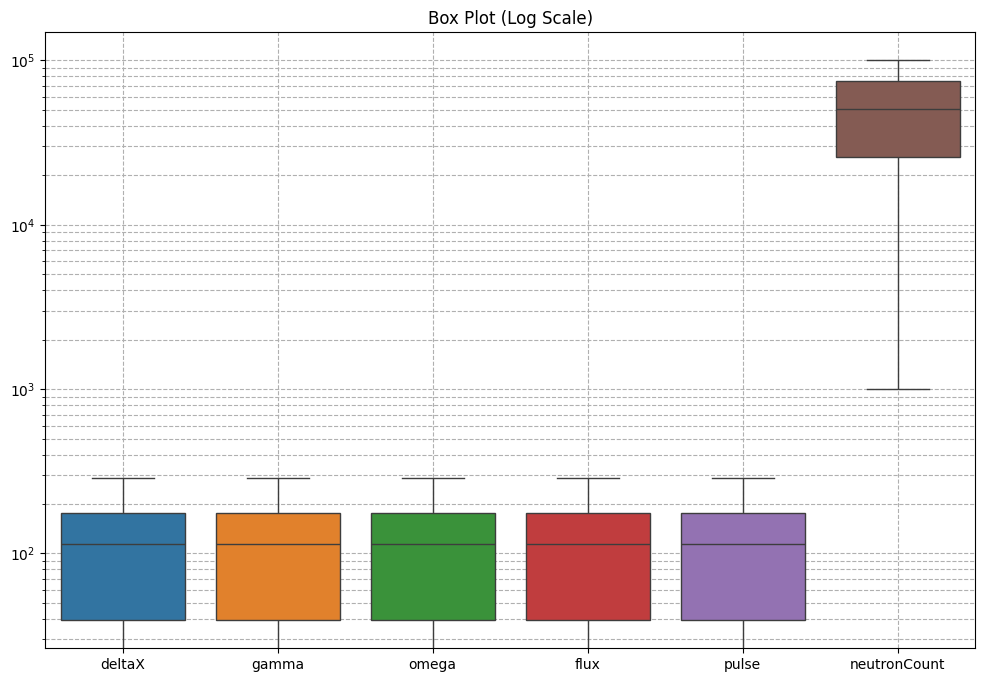

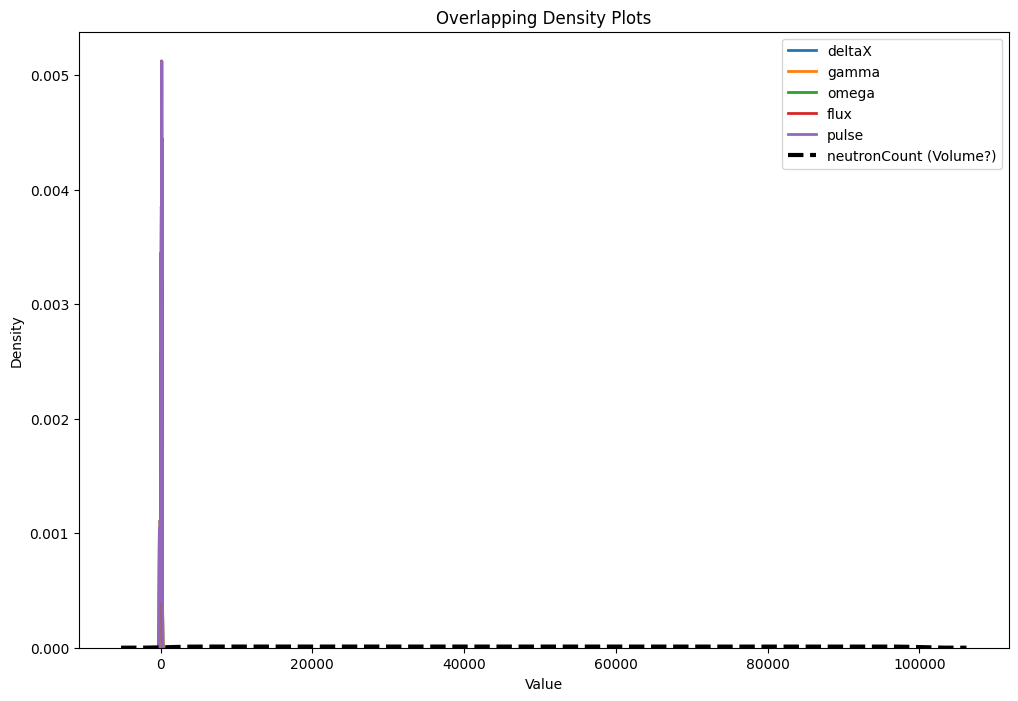

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def load_data(filepath):
    df = pd.read_csv(filepath)
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    return df

def infer_columns(df):
    corr_mean = df.corr().abs().mean().sort_values()
    volume_col = corr_mean.index[0]
    price_cols = [col for col in df.columns if col != volume_col]
    return volume_col, price_cols

def display_summary(df):
    display(df.describe())

def plot_boxplot(df):
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df)
    plt.title('Box Plot (Log Scale)')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.show()

def plot_kde(df, price_cols, volume_col):
    plt.figure(figsize=(12, 8))
    for col in price_cols:
        sns.kdeplot(df[col], label=col, lw=2)
    sns.kdeplot(df[volume_col], label=f"{volume_col} (Volume?)", color='black', ls='--', lw=3)
    plt.title('Overlapping Density Plots')
    plt.xlabel('Value')
    plt.legend()
    plt.show()

def plot_correlations(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(method='pearson'), annot=True, cmap='viridis', fmt=".7f")
    plt.title('Pearson Correlation Matrix')
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(method='spearman'), annot=True, cmap='magma', fmt=".7f")
    plt.title('Spearman Rank Correlation Matrix')
    plt.show()

def plot_pairplot(df, price_cols):
    sns.pairplot(df[price_cols], corner=True, plot_kws={'alpha': 0.5})
    plt.suptitle('Pair Plot of Price Columns', y=1.02)
    plt.show()

def plot_timeseries(df, price_cols, volume_col):
    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax2 = ax1.twinx()

    for col in price_cols:
        ax1.plot(df.index, df[col], label=col, alpha=0.8)
    ax2.bar(df.index, df[volume_col], label=volume_col, color='gray', alpha=0.3)

    ax1.set_xlabel('Index')
    ax1.set_ylabel('Price-like Values')
    ax2.set_ylabel('Volume-like Value')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title('Time-Series: Prices & Volume')
    plt.show()

def plot_rolling_volatility(df, price_cols, window=20):
    plt.figure(figsize=(15, 8))
    for col in price_cols:
        df[col].rolling(window=window).std().plot(label=f'{col}')
    plt.title(f'{window}-Period Rolling Volatility')
    plt.xlabel('Index')
    plt.ylabel('Rolling Std Dev')
    plt.legend()
    plt.grid(True, ls='--')
    plt.show()

def plot_high_low_counts(df, price_cols):
    df_prices = df[price_cols]
    is_max = df_prices.eq(df_prices.max(axis=1), axis=0)
    is_min = df_prices.eq(df_prices.min(axis=1), axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    is_max.sum().sort_values().plot(kind='barh', ax=ax1, color='forestgreen')
    ax1.set_title("Times Each Column Was Max")

    is_min.sum().sort_values().plot(kind='barh', ax=ax2, color='firebrick')
    ax2.set_title("Times Each Column Was Min")

    plt.suptitle("High/Low Identity Counts", fontsize=16)
    plt.tight_layout()
    plt.show()

df = load_data("02_sample_data_with_fabricated_columns.csv")
volume_col, price_cols = infer_columns(df)

display_summary(df)
plot_boxplot(df)
plot_kde(df, price_cols, volume_col)

## As can be seen with the above two diagrams, neutronCount is indeed volumne

1. With the first box-plot we see neutronCount having very different statistical values and hence this clearly tells us that it maps to volume.
2. The second diagram shows the `Kernel Density Estimation Plots` of all the columns. `deltaX`, `gamma`, `omega`, `flux` and `pulse` have more or less overlapping density. However `neutronCount` has a significantly varying density.

# Correlation Matrices

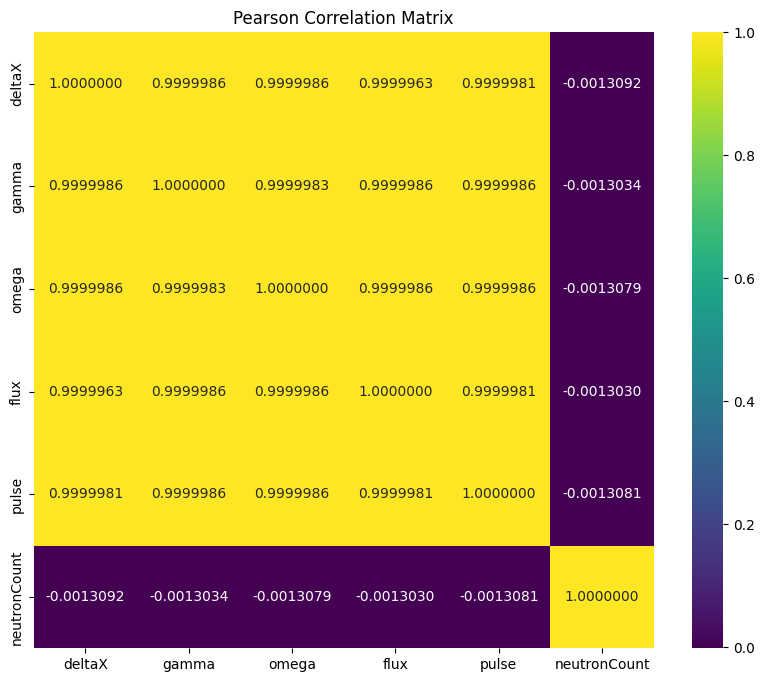

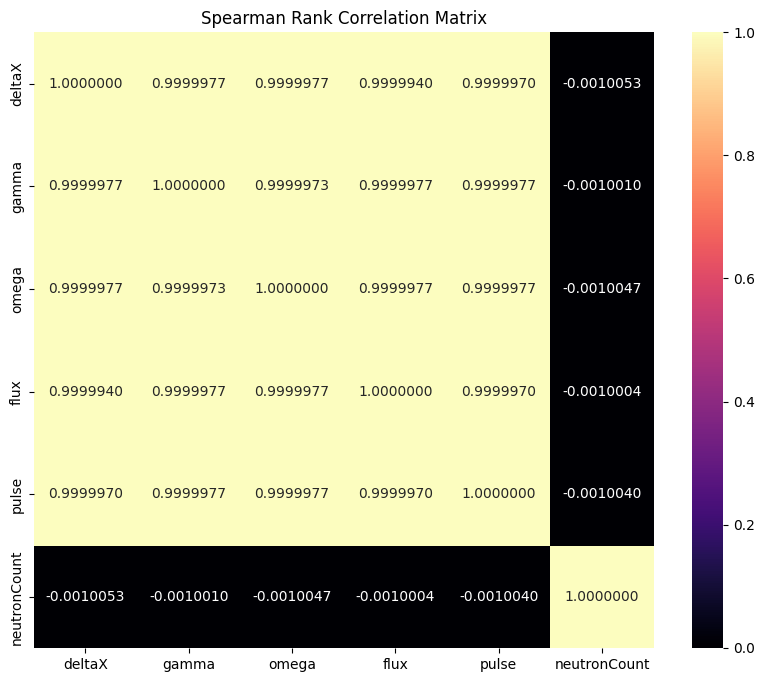

In [6]:
plot_correlations(df)

# Finding high and low
We see that 2 columns - `gamma` and `omega` are greater than and less than (resprectively) every other remanining column, except `pulse`.

To calculate the bounds (low and high) from the data, we came up with the idea of taking the minimum and maximum from each row and find the columns which give minimum and maximum for most of the values in the dataset after keeping aside the column for volume (`neutronCount`).

Frequency of each column being the ROW-WISE MAXIMUM:
| Column | Frequency  |
|--------|------------|
| gamma  | 432559     |
| pulse  | 67441      |

(others 0)

Frequency of each column being the ROW-WISE MINIMUM:
| Column | Frequency  |
|--------|------------|
| omega  | 432906     |
| pulse  | 67094      |

(others 0)

From the tables above, we infer that after keeping aside the column for volume (`neutronCount`) the values in the column `gamma` are the maximum for `432559` values which is the highest and thus we can very confidently suggest that `gamma` is indeed the maximum and maps to the actual column `high`.

Similarly, we consolidated the results for all the times each column is the minimum of all the columns for all values as shown in Table (3?) and found that the column `omega` is lowest for most times `432906` and thus maps to the actual column `low`.


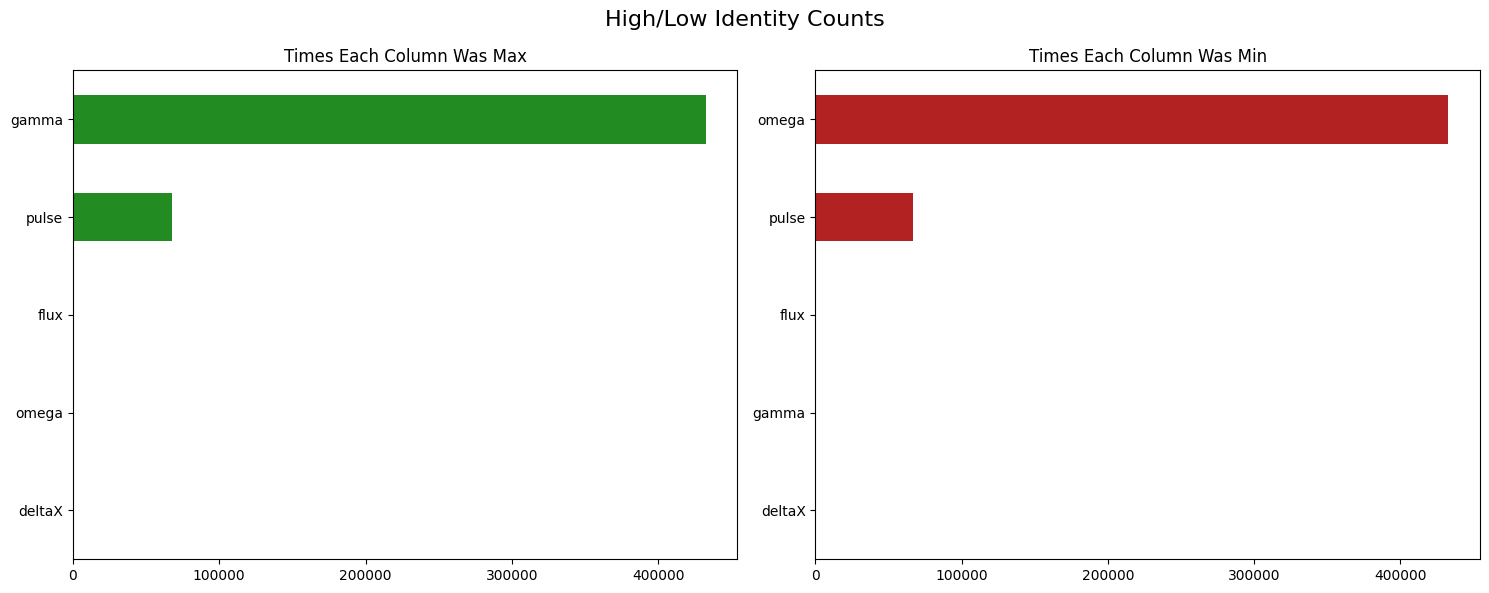

In [8]:
plot_high_low_counts(df, price_cols)

In [4]:
dx = df["deltaX"]
gamma = df["gamma"]
omega = df["omega"]
flux = df["flux"]
pulse = df["pulse"]

for a, b, c, d in zip(dx, gamma, omega, flux):
    if b < a or b < c or b < d:
        print("Violation!!")
    
print("gamma is high")

for a, b, c, d in zip(dx, gamma, omega, flux):
    if a < c or b < c or d < c:
        print("Violation!!")
    
print("omega is low")


gamma is high
omega is low


# Finding Column which maps to Price

Since low <= open <= high and low <= close <= high, `pulse` must be price, since it is the only column to not follow this trend

Now we are tasked with mapping `deltaX` and `flux` to open and close. To do this we use the following methods

# Finding open / close

## This was the trickest part and we employed three separate methods to get the right mapping
## All three of them hinted at the same mapping.

## Method 1: Using Candle Stick Plots

## Hypothesis 1 (which we later deduce as correct)

<img src="images/hyp_1.png" width=700>
<img src="images/hyp_1_circles.png" width=700>

### Analysing one segment
<img src="images/hyp_1_part_1.png" width=900>


As we can see, green candles (bullish market: close > open) entail upward movement, while red candle (bearish market: close < open) entail downward movement

### Analysing another segment
<img src="images/hyp_1_part_2.png" width=700>

We see a similar trend here. Green candles lead to increase in the open rate of the stock

## Hypothesis 2 (which we later deduce as incorrect)
<img src="images/hyp_2.png" width=700>
<img src="images/hyp_2_circles.png" width=700>

### Analysing one segment
<img src="images/hyp_2_part_1.png" width=900>

### Analysing another segment
<img src="images/hyp_2_part_2.png" width=900>

In both of these segments, we see unexpected results. Red candles are leading to upward movement, while green candles are leading to downward movement

## Method 2: Using regression model
* We can use the data of the past days to predict the present movement of the stock. Thus, we fit a regression model to predict the change in opening price given the momentum (close - open) of the past 4 days.
* The hypothesis is that positive momentum should cause growth and negative momentum should cause decline. Thus, if we use the correct mappings, we should get positive values of the coefficients.



In [5]:
X = []
y = []

for i in range (5, len(dx)):
    nx = []
    for j in range (4):
        nx.append(-(dx[i-5+j] - flux[i-5+j]))


    X.append(nx)
    y.append(dx[i] - dx[i-1])

import statsmodels.api as sm
import numpy as np

X = np.array(X)
y = np.array(y)

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.583
Date:                Mon, 14 Jul 2025   Prob (F-statistic):              0.176
Time:                        01:17:13   Log-Likelihood:            -4.3248e+05
No. Observations:              499995   AIC:                         8.650e+05
Df Residuals:                  499990   BIC:                         8.650e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.721      0.4

# Observations
* We see that the coefficients are positive, albeit very small. Also, recent days get a greater coefficient than older ones (which is expected).
* To get confidence values, we check the number of predictions for which the parity (+ve/-ve) matches the actual parity. This number is very close to 0.5 (random chance), but shows a small bias towards `deltaX` ~ open and `flux` ~ close

In [6]:
y_pred = model.predict(X)
conf = sum(a * b > 0 for a, b in zip(y, y_pred)) / len(y_pred)
print(conf)

0.5017030170301703


## Method 3: A Self-Defined Custom Sliding Window DP Algorithm

### Working of the DP Algorithm

1. **Find candidates**
   - Figures out which columns could be Open or Close:
`oc_candidates = all columns MINUS known High, Low, Price and Volume.`

2. **Define all possible (Open, Close) pairs**

3. **Run a dynamic programming loop**

   - For each time step (row in the data):
       - For each possible (Open, Close) pair:
           - Compute the cost of transitioning from the previous pair to this one.
           - Cost = difference between today’s Open and yesterday’s Close, plus an extra penalty if you switch mappings.
   - Store the minimum cost path.

4. **Backtrack**
   - After the forward pass, backtrace to get the optimal sequence of states (mappings).

5. **Find the most frequent mapping**
   - The most common (Open, Close) pair along the optimal path is assumed to be the real mapping.

In [ ]:
import pandas as pd
import numpy as np
from itertools import permutations

DATA_FILE_PATH = "02_sample_data_with_fabricated_columns.csv"

KNOWN_HIGH = 'gamma'
KNOWN_LOW = 'omega'
KNOWN_VOLUME = 'neutronCount'
KNOWN_PRICE = 'pulse'

def solve_open_close_with_dp(file_path, high_col, low_col, volume_col, price_column, switching_penalty=0.1):
    print("Dynamic Programming Solver for Open/Close")
    
    df = pd.read_csv(file_path)
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    known_cols = [high_col, low_col, volume_col, price_column]
    oc_candidates = [c for c in df.columns if c not in known_cols]
    
    states = list(permutations(oc_candidates, 2))
    num_states = len(states)
    num_timesteps = len(df)
    
    print(f"Candidates for Open/Close: {oc_candidates}")
    print(f"Number of possible states (mappings): {num_states}")
    for i, state in enumerate(states):
        print(f"  State {i}: Open={state[0]}, Close={state[1]}")

 
    cost_matrix = np.full((num_timesteps, num_states), np.inf)
    backpointer_matrix = np.zeros((num_timesteps, num_states), dtype=int)
    
    cost_matrix[0, :] = 0

    print("\nRunning forward pass of the Viterbi algorithm...")
    for t in range(1, num_timesteps):
        if t % 10000 == 0:
            print(f"Processing timestep {t}/{num_timesteps}")
            
        for j, current_state in enumerate(states):
            open_j = current_state[0]
            
            min_cost = np.inf
            best_prev_state_idx = -1
            
            for i, prev_state in enumerate(states):
                close_i = prev_state[1]
                
                transition_cost = abs(df[open_j].iloc[t] - df[close_i].iloc[t-1])
                penalty = switching_penalty if i != j else 0
                
                total_cost = cost_matrix[t-1, i] + transition_cost + penalty
                
                if total_cost < min_cost:
                    min_cost = total_cost
                    best_prev_state_idx = i
            
            cost_matrix[t, j] = min_cost
            backpointer_matrix[t, j] = best_prev_state_idx
            
    optimal_path = np.zeros(num_timesteps, dtype=int)
    
    optimal_path[-1] = np.argmin(cost_matrix[-1, :])
    
    for t in range(num_timesteps - 2, -1, -1):
        optimal_path[t] = backpointer_matrix[t + 1, optimal_path[t + 1]]

    print("\n--- Results ---")
    path_in_words = [f"O={states[i][0]}, C={states[i][1]}" for i in optimal_path]
    results_df = pd.DataFrame({'Optimal Mapping': path_in_words})
    
    most_likely_mapping_counts = results_df['Optimal Mapping'].value_counts()
    
    print("The most frequent mapping found across the entire dataset was:")
    print(most_likely_mapping_counts.head(1))
    
    return most_likely_mapping_counts

if __name__ == "__main__":
    most_likely_mapping = solve_open_close_with_dp(DATA_FILE_PATH, high_col=KNOWN_HIGH, low_col=KNOWN_LOW, volume_col=KNOWN_VOLUME, price_column=KNOWN_PRICE,switching_penalty=0.1)

Dynamic Programming Solver for Open/Close
Candidates for Open/Close: ['deltaX', 'flux']
Number of possible states (mappings): 2
  State 0: Open=deltaX, Close=flux
  State 1: Open=flux, Close=deltaX

Running forward pass of the Viterbi algorithm...
Processing timestep 10000/500000
Processing timestep 20000/500000
Processing timestep 30000/500000
Processing timestep 40000/500000
Processing timestep 50000/500000
Processing timestep 60000/500000
Processing timestep 70000/500000
Processing timestep 80000/500000
Processing timestep 90000/500000
Processing timestep 100000/500000
Processing timestep 110000/500000
Processing timestep 120000/500000
Processing timestep 130000/500000
Processing timestep 140000/500000
Processing timestep 150000/500000
Processing timestep 160000/500000
Processing timestep 170000/500000
Processing timestep 180000/500000
Processing timestep 190000/500000
Processing timestep 200000/500000
Processing timestep 210000/500000
Processing timestep 220000/500000
Processing ti

The above also shows that `deltaX` is open and `flux` is close, but that is true for only 266973 / 500000 samples, which is roughly 0.53 of the total. This is again, very close to random chance (0.5), but shows a small bias towards our previous finding (using the regression model). Thus, 

`deltaX`: open  
`flux`: close